In [1]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

In [ ]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [ ]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"{split}에 있는 질문 개수: {df['id'].nunique()}")

train에 있는 질문 개수: 1295
test에 있는 질문 개수: 358
validation에 있는 질문 개수: 255


In [ ]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [ ]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx   = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

In [ ]:
import matplotlib.pyplot as plt

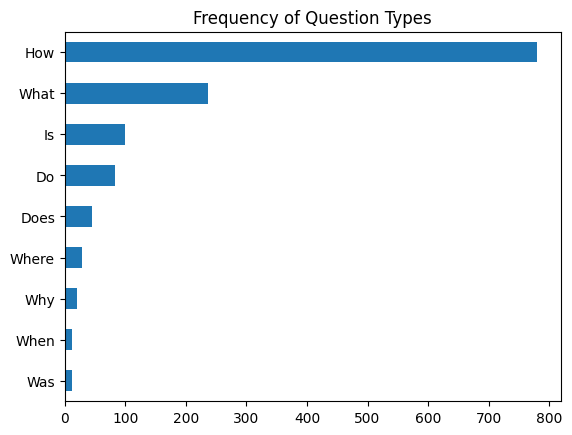

In [ ]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why", "When"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [ ]:
for question_type in ["How", "What", "Is", "When"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?
When the setup is complete?
When was that video recorded?
When the headphone cable are short?


In [ ]:
from transformers import AutoTokenizer

In [ ]:
model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on file size."""
inputs = tokenizer(question, context, return_tensors="pt")

inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [ ]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)

print(outputs)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [ ]:
start_logits = outputs.start_logits
end_logits   = outputs.end_logits

In [ ]:
print(f"{inputs.input_ids.size()}")
print(f"{start_logits.size()}")
print(f"{end_logits.size()}")

torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])


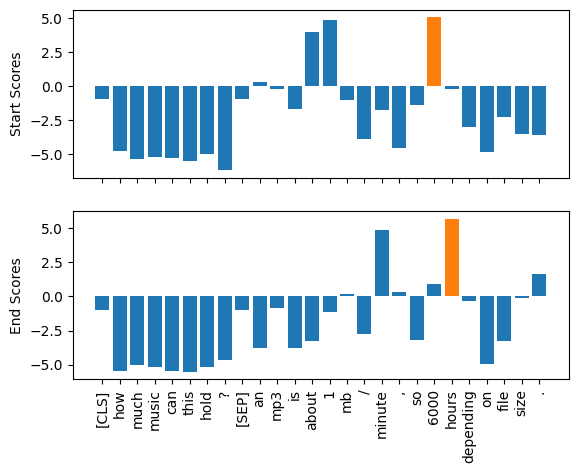

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")

colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")

plt.xticks(rotation="vertical")
plt.show()

In [ ]:
import torch

start_idx = torch.argmax(start_logits)
end_idx   = torch.argmax(end_logits) + 1

answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)

print(f"question : {question}")
print(f"answer : {answer}")

question : How much music can this hold?
answer : 6000 hours


In [ ]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)   # handle_impossible_answer = True -> 답변 불가 질문은 빈 문자열로 매핑
pipe(question=question, context=context, topk=3)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/transformers/pipelines/question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.26516109704971313,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.22082959115505219,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253564268350601,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [ ]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, max_length=100,
                              stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"#{idx} 윈도에는 {len(window)} 개의 토큰이 있습니다.")

#0 윈도에는 100 개의 토큰이 있습니다.
#1 윈도에는 88 개의 토큰이 있습니다.


In [ ]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



https://docs.haystack.deepset.ai/docs/document_store

In [ ]:
from haystack.document_stores import ElasticsearchDocumentStore

document_store = ElasticsearchDocumentStore(host = "localhost",
                                            port = 9200,
                                            embedding_dim = 768)

/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


In [ ]:
for split, df in dfs.items():
    docs = [{"content": row["context"],
             "meta":{
                 "item_id": row["title"],
                 "question_id": row["id"],
                 "split": split
                 }
            }
        for _, row in df.drop_duplicates(subset="context").iterrows()
        ]
    #document_store.write_documents(docs, index="document")
    document_store.write_documents(docs)

print(f"{document_store.get_document_count()} 개 문서 저장 완료.")

1615 개 문서 저장 완료.


## Retriever Evaluation

https://github.com/rickiepark/nlp-with-transformers/blob/2c9d4a1c9c7555802d7a974cd3cf0b1481663122/07_question-answering_v2.ipynb

In [ ]:
from haystack.nodes import EmbeddingRetriever, BM25Retriever

In [ ]:
#retriever = EmbeddingRetriever(
#    document_store=document_store, embedding_model="sentence-transformers/multi-qa-mpnet-base-dot-v1"
#)
#document_store.update_embeddings(retriever)
retriever = BM25Retriever(document_store=document_store)

In [ ]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = retriever.retrieve(query=query, top_k=3, filters={"item_id": [item_id], "split": ["train"]})

In [ ]:
print(retrieved_docs[0].content)
print(retrieved_docs[0].score)

This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.
0.6848808100188896


In [ ]:
from haystack.nodes import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
reader = FARMReader(model_name_or_path=model_ckpt, use_gpu=False)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
reader.predict_on_texts(question=question, texts=[context], top_k=1)

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  7.65 Batches/s]


{'query': 'How much music can this hold?',
 'no_ans_gap': 12.648082256317139,
 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.5296427607536316, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}], 'offsets_in_context': [{'start': 38, 'end': 48}], 'document_ids': ['e344757014e804eff50faa3ecf1c9c75'], 'meta': {}}>]}

In [ ]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, retriever)

In [ ]:
prediction = pipe.run(
    query=query, params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 5}}
)

/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
Inferencing Samples: 100%|██████████| 1/1 [00:01<00:00,  1.18s/ Batches]


In [ ]:
from haystack.utils import print_answers

print_answers(prediction, details="minimum")

'Query: Is it good for reading?'
'Answers:'
[   {   'answer': 'They sound great',
        'context': 'ws were mostly positive and the price was right so I '
                   'bought them.  They sound great. I am no audiophile so take '
                   "my review for what it's worth. The pri"},
    {   'answer': 'It is materially better than reading a physical magazine',
        'context': 'ted magazines covering travel, sports or food. It is '
                   'materially better than reading a physical magazine. For '
                   'this purpose I might have wanted the iPad'},
    {   'answer': 'This is a good tablet for reading books',
        'context': ' I expect of a tablet.The text is very clear and sharp. '
                   'This is a good tablet for reading books, which is more '
                   'than I expected.There is the one small '},
    {   'answer': "it's good",
        'context': 'od digital photo frame. Not worlds better than others you '
              

https://haystack.deepset.ai/tutorials/11_pipelines

In [ ]:
from haystack import Label, Answer, Document

labels = []
for i, row in dfs["test"].iterrows():
    # 리트리버에서 필터링을 위해 사용하는 메타데이터
    meta = {"item_id": row["title"], "question_id": row["id"]}
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], answer=Answer(answer=answer), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False, filters={"item_id": [meta["item_id"]], "split":["test"]})
            labels.append(label)
    else:
        label = Label(
            query=row["question"], answer=Answer(answer=""), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True, filters={"item_id": [row["title"]], "split":["test"]})
        labels.append(label)

In [ ]:
print(labels[0])

<Label: {'id': '46612b96-b0a3-44ca-8e8c-0749e4d818c4', 'query': 'What is the tonal balance of these headphones?', 'document': {'id': 'f011c75fb8d26066217e64b3ff470d84', 'content': "I have been a headphone fanatic for thirty years and have owned and used a variety of headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580.  The Sony MDRV6 excells as the best value of any headphone that I've ever owned.  They are especially good at producing natural-sounding deep bass, and the overall octave-to-octave balance is excellent.  The sound quality is all in all comparable to other headphones that cost considerably more.The MDRV6 is especially well-suited for travel due to the collapsible design, and for noisy environments or for quiet environments such as a library where the sound emitted by open-back headphones would distract others.The MDRV6 is not quite as comfortable as some other headphones, but the comfort can be improved enormously by replacing the pads with the 

In [ ]:
document_store.write_labels(labels, index="label")
print(f"""{document_store.get_label_count(index="label")}개의 질문 답변 쌍을 로드했습니다.""")

1365개의 질문 답변 쌍을 로드했습니다.


In [ ]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

330


In [ ]:
labels_agg[109]

<MultiLabel: {'labels': [{'id': '0aa3a2ff-9098-471b-a183-2ce040b8e244', 'query': 'How does the fan work?', 'document': {'id': 'a5db4d52bb4d0fcadff2b8a6f4e54d75', 'content': 'the usb on the back caused my mac to restart when i would plug something into about 50% of the time.  very annoying but the fan is really really good!', 'content_type': 'text', 'meta': {}, 'id_hash_keys': ['content'], 'score': None, 'embedding': None}, 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'gold-label', 'answer': {'answer': 'the fan is really really good', 'type': 'extractive', 'score': None, 'context': None, 'offsets_in_document': None, 'offsets_in_context': None, 'document_ids': None, 'meta': {}}, 'pipeline_id': None, 'created_at': '2024-02-12 15:38:58', 'updated_at': '2024-02-12 15:38:58', 'meta': {'item_id': 'B002MU1ZRS', 'question_id': '5a9b7616541f700f103d21f8ad41bc4b'}, 'filters': {'item_id': ['B002MU1ZRS'], 'split': ['test']}}, {'id': '7fa8e62b-7cce-4da9-96ab-a0e3633759cd', 'quer

In [ ]:
eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 3}},
)
metrics = eval_result.calculate_metrics()

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.65 Batches/s]
/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.33 Batches/s]
/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
Inferencing 

In [ ]:
print(f"재현율@3: {metrics['Retriever']['recall_single_hit']:.2f}")

재현율@3: 0.95


In [ ]:
eval_df = eval_result["Retriever"]
eval_df[eval_df["query"] == "How do you like the lens?"][["query", "filters", "rank", "document_id", "gold_document_ids", "gold_id_match"]]

,query,filters,rank,document_id,gold_document_ids,gold_id_match
3,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",1.0,3566c491f5aafe80a22667754727dfc0,[fac2e8bec06035a70307dd1e8034ea63],0.0
4,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",2.0,d5c7736727a38c2fe62df10beef4a5ce,[fac2e8bec06035a70307dd1e8034ea63],0.0
8,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",1.0,ebfb4b46819be7c051b27f0c28efd0fb,[],0.0
9,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",2.0,94163306f4c5c35c83ed165b2282cd32,[],0.0
10,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",3.0,7f5d77178fe93006124f731249d245f8,[],0.0
133,How do you like the lens?,"b'{""item_id"": [""B0025EWXEU""], ""split"": [""test""]}'",1.0,11818a689fbac56cbb063eb658b22c05,"[47f76b8f62cf296d394d993741d660aa, 47f76b8f62c...",0.0


In [ ]:
from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=retriever)

In [ ]:
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}
    # 최대 top_k를 계산합니다
    max_top_k = max(topk_values)
    # 파이프라인을 만듭니다
    p = DocumentSearchPipeline(retriever=retriever)
    # 테스트 세트에 있는 질문-답변 쌍을 순회하면서 최대 top_k로 추론을 실행합니다
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}},
    )
    # 각 top_k 값에 대해 재현율을 계산합니다
    for topk in topk_values:
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}
        
    return pd.DataFrame.from_dict(topk_results, orient="index")


topk_df = evaluate_retriever(retriever)

/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security 

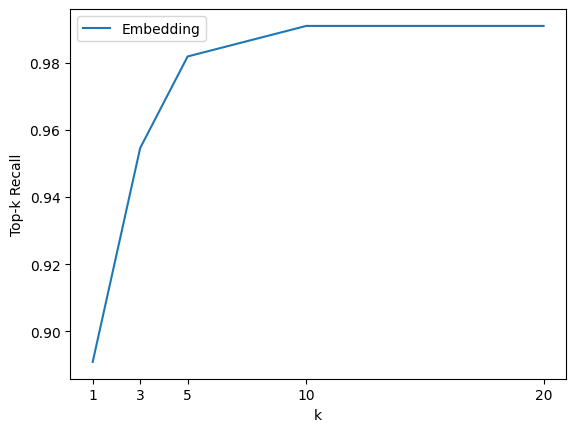

In [ ]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()
    
plot_retriever_eval([topk_df], ["Embedding"])

## Dense Passage Retrieval

In [ ]:
from haystack.nodes import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)

In [ ]:
document_store.update_embeddings(retriever=dpr_retriever)

/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
Updating embeddings: 10000 Docs [00:33, 302.06 Docs/s]          


/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security 

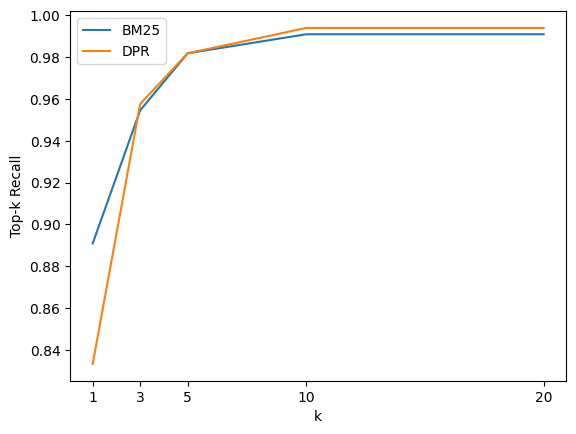

In [ ]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([topk_df, dpr_topk_df], ["BM25", "DPR"])

## Reader Evaluation

In [ ]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

# 두 지표를 모두 참고해 모델 성능의 과소평가(EM) 와 과대평가 (F1-score) 사이에서 균형을 잡는게 좋다.
#pred = "about 6000 hours"
pred = "about 6000 dollars"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4


In [ ]:
from haystack.pipelines import Pipeline
def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
                
    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  5.14 Batches/s]


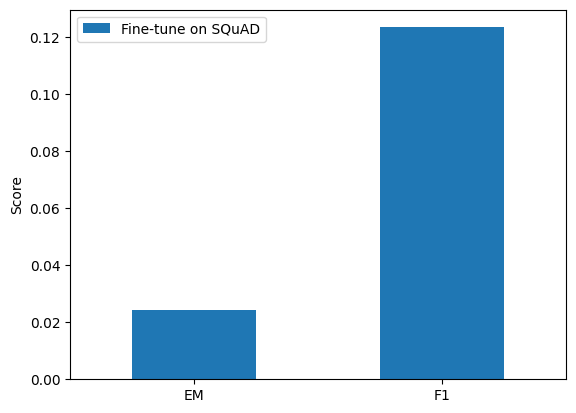

In [ ]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval)
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

## Domain Apaptation

In [ ]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # 특정 문맥으로 전체 질문-답 쌍을 필터링합니다
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # qas 배열을 만듭니다
        for qid, question in id2question.items():
            # 하나의 질문 ID에 대해 필터링합니다
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # 답변 가능한 질문을 추가합니다
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # 질문-답 쌍을 qas에 추가합니다
            qas.append({"question": question, "id": qid, 
                        "is_impossible": is_impossible, "answers": answers})
        # 문맥과 질문-답 쌍을 paragraphs에 추가합니다
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

In [ ]:
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

In [ ]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # 각 제품 ID에 대해 `paragraphs`를 만듭니다
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # 결과를 디스크에 저장합니다
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)
            
convert_to_squad(dfs)

In [ ]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

reader.train(data_dir=".", use_gpu=False, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing dataset:   0%|          | 0/3 [00:00<?, ? Dicts/s]

Preprocessing dataset:  33%|███▎      | 1/3 [00:00<00:00,  2.09 Dicts/s]Answer using start/end indices is '  Operation of the menus and contro' while gold label text is 'Operation of the menus and controls'.
Example will not be converted for training/evaluation.
Answer using start/end indices is '  This camera performs like the pros.  Fast accurate and easy to operat' while gold label text is 'This camera performs like the pros.  Fast accurate and easy to operated'.
Example will not be converted for training/evaluation.
Preprocessing dataset:  67%|██████▋   | 2/3 [00:01<00:00,  1.94 Dicts/s]Answer 'enjoy my music.  When I used my old one ear headset for music, the connection was not that good even if I put the phone in my pants pocket.  I used it on iPhone 4S and iPad 3 for music, phone calls, and audible app.  All Bluetooth controls work fine. ANSWERNOTFOUND' not contained in context.
Example will not be converted for training/evaluation.
Answer 'is good.  First unit defective.  Direc

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  5.23 Batches/s]


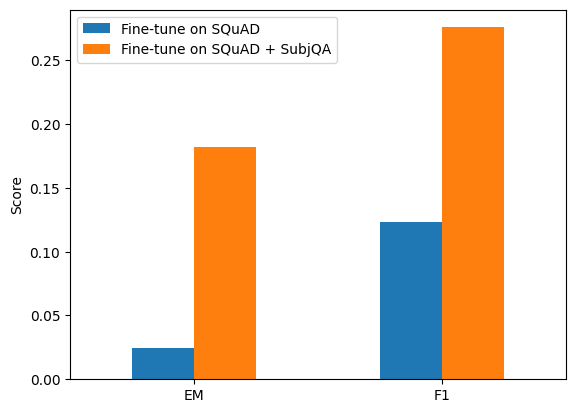

In [ ]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)
plot_reader_eval(reader_eval)

In [ ]:
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)

In [ ]:
minilm_reader.train(data_dir=".", use_gpu=False, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

전체 QA 파이프라인 평가하기

In [ ]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(retriever=retriever, reader=reader)

# 평가하기
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# 리더에서 지표를 추출합니다
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.23 Batches/s]
/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.19 Batches/s]
/Users/parkh

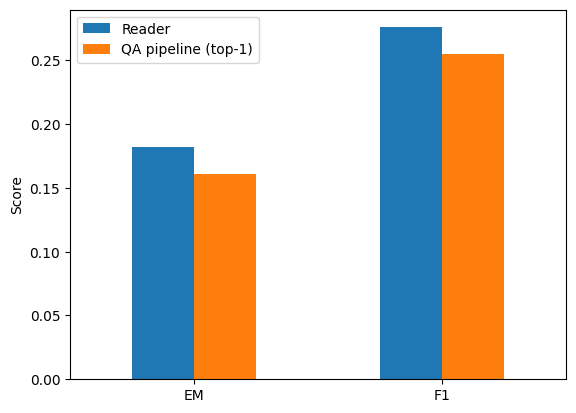

In [ ]:
# 리더와 전체 QA 파이프라인의 EM과 F1-점수 비교
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

In [ ]:
# 또는 QA 파이프라인과 리더 지표를 한번에 얻습니다
# 리더 평가는 시뮬레이트된 완벽한 리트리버 결과를 사용해 두 번째로 실행됩니다
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
    add_isolated_node_eval=True
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# 시뮬레이트된 완벽한 리트리버로 격리되어 실행된 리더로부터 지표를 추출합니다
isolated_metrics = eval_result.calculate_metrics(simulated_top_k_reader=1, eval_mode="isolated")

pipeline_reader_eval = {}
pipeline_reader_eval["Reader"] = {
    k:v for k,v in isolated_metrics["Reader"].items()
    if k in ["exact_match", "f1"]}
pipeline_reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

plot_reader_eval(pipeline_reader_eval)

## RAG

Installing farm-haystack and haystack-ai in the same Python environment (virtualenv, Colab, or system) causes problems.  
(https://docs.haystack.deepset.ai/docs/installation)  
pip uninstall -y farm-haystack haystack-ai  
pip install haystack-ai

In [1]:
import pandas as pd
from haystack.utils import fetch_archive_from_http

# Download sample
doc_dir = "data/tutorial7/"
s3_url = "https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/small_generator_dataset.csv.zip"
fetch_archive_from_http(url=s3_url, output_dir=doc_dir)

# Create dataframe with columns "title" and "text"
df = pd.read_csv(f"{doc_dir}/small_generator_dataset.csv", sep=",")
# Minimal cleaning
df.fillna(value="", inplace=True)

print(df.head())


/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


               title                                               text
0  "Albert Einstein"  to Einstein in 1922. Footnotes Citations Alber...
1  "Albert Einstein"  Albert Einstein Albert Einstein (; ; 14 March ...
2  "Albert Einstein"  observations were published in the internation...
3  "Albert Einstein"  model for depictions of mad scientists and abs...
4     "Alfred Nobel"  was adopted as the standard technology for min...


In [2]:
from haystack import Document

# Use data to initialize Document objects
titles = list(df["title"].values)
texts = list(df["text"].values)
documents = []
for title, text in zip(titles, texts):
    documents.append(Document(content=text, meta={"name": title or ""}))

In [3]:
from haystack.document_stores import FAISSDocumentStore

document_store = FAISSDocumentStore(faiss_index_factory_str="Flat", return_embedding=True)

In [4]:
from haystack.nodes import RAGenerator, DensePassageRetriever
# As of version 1.16, RAGenerator has been deprecated in Haystack and completely removed from Haystack as of v1.18.  (https://haystack.deepset.ai/tutorials/07_rag_generator)

retriever = DensePassageRetriever(
    document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    use_gpu=True,
    embed_title=True,
)

ImportError: cannot import name 'RAGenerator' from 'haystack.nodes' (/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/haystack/nodes/__init__.py)

https://haystack.deepset.ai/tutorials/22_pipeline_with_promptnode

In [5]:
from haystack.document_stores import InMemoryDocumentStore

document_store = InMemoryDocumentStore(use_bm25=True)

In [6]:
from datasets import load_dataset

dataset = load_dataset("bilgeyucel/seven-wonders", split="train")
document_store.write_documents(dataset)

Generating train split: 151 examples [00:00, 9053.27 examples/s]
Updating BM25 representation...: 100%|██████████| 151/151 [00:00<00:00, 21881.56 docs/s]


In [7]:
from haystack.nodes import BM25Retriever

retriever = BM25Retriever(document_store=document_store, top_k=2)

In [ ]:
import os
from getpass import getpass

openai_api_key = os.getenv("OPENAI_API_KEY", None) or getpass("Enter OpenAI API key:")

In [ ]:
from haystack.nodes import PromptNode, PromptTemplate, AnswerParser

rag_prompt = PromptTemplate(
    prompt="""Synthesize a comprehensive answer from the following text for the given question.
                             Provide a clear and concise response that summarizes the key points and information presented in the text.
                             Your answer should be in your own words and be no longer than 50 words.
                             \n\n Related text: {join(documents)} \n\n Question: {query} \n\n Answer:""",
    output_parser=AnswerParser(),
)

prompt_node = PromptNode(model_name_or_path="gpt-3.5-turbo", api_key=openai_api_key, default_prompt_template=rag_prompt)

In [ ]:
from haystack.pipelines import Pipeline

pipe = Pipeline()
pipe.add_node(component=retriever, name="retriever", inputs=["Query"])
pipe.add_node(component=prompt_node, name="prompt_node", inputs=["retriever"])

In [ ]:
output = pipe.run(query="What does Rhodes Statue look like?")

print(output["answers"][0].answer)

In [ ]:
examples = [
    "Where is Gardens of Babylon?",
    "Why did people build Great Pyramid of Giza?",
    "What does Rhodes Statue look like?",
    "Why did people visit the Temple of Artemis?",
    "What is the importance of Colossus of Rhodes?",
    "What happened to the Tomb of Mausolus?",
    "How did Colossus of Rhodes collapse?",
]